# Выпускной проект: Анализ клиентов "МетанпромБанка"

## Описание проекта

### Описание задачи исследования

**Анализ оттока клиентов МетанпромБанка**

**Цель**: удержать клиентов банка, уменьшить отток

**Задача**: проанализировать клиентов банка и выделить портреты клиентов склонных к оттоку. Дать рекомендации по удержанию клиентов.


### Описание данных

Название признака|Описание признака
---|---
userid|— идентификатор пользователя;
score|— баллы кредитного скоринга;
City|— город;
Gender|— пол;
Age|— возраст;
Objects|— количество объектов в собственности;
Balance |— баланс на счёте;
Products |— количество продуктов, которыми пользуется клиент;
CreditCard | — есть ли кредитная карта;
Loyalty | — активный клиент;
estimated_salary | — заработная плата клиента;
Churn| — ушёл или нет.


## Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats as st

# отключаю предупреждение anaconda
import warnings
warnings.simplefilter('ignore')


## Обзор данных

### Загрузка данных

In [ ]:
df = pd.read_csv('bank_dataset.csv')

### Изучение данных

**Общие сведения о датафрейме**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [ ]:
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.describe()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Вывод:**
 - типы данных не требуют корректировки;
 - в колонке Balance обнаружено много пропусков;
 - названия колонок требуется привести в соответствии со стилем camel_case.

## Предобработка данных

### Приведение названий столбцов к стилю camel_case

In [ ]:
df = df.rename(columns={'userid':'user_id',
                        'City':'city',
                        'Gender':'gender',
                        'Age':'age',
                        'Objects':'objects',
                        'Balance':'balance',
                        'Products':'products',
                        'CreditCard':'credit_card',
                        'Loyalty':'loyalty',
                        'Churn':'churn'})

### Приведение типов данных

### Избавление от явных дубликатов

**Количество дубликатов**

In [ ]:
df.duplicated().sum()

0

**Вывод:** явных дубликатов не обнаружено

### Заполнение пропусков

**Количество пропусков**

In [ ]:
df.isna().sum()

user_id                0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

**Вывод:** в колонке balance обнаружено большое число пропусков. Для того, чтобы верно заполнить пропущенные значения желательно установить зависимость пропусков от других признаков датафрейма

#### Исследование природы пропусков

Изучение пропусков с разбивкой по качественным признакам

In [ ]:
# признаки по которым будет проводится группировка
signs = ['city', 'gender', 'objects','products', 'credit_card','loyalty', 'churn']

for sign in signs:

    for val in df[sign].unique():
        print('Признак', sign,'значение', val)
        #общее количество записей в данных для такой пары признак-значение
        num_of_rows = df[df[sign]==val]['user_id'].count()
        #общее число пропусков
        abs_null_rows = df[df[sign]==val]['balance'].isna().sum()
        #доля пропущенных значений
        ratio_null_rows = abs_null_rows/num_of_rows
        print('Абсолютное кол-во пропусков', abs_null_rows)
        print('Доля пропущенных значений от общего числа записей', ratio_null_rows)
        print()

Признак city значение Ярославль
Абсолютное кол-во пропусков 2418
Доля пропущенных значений от общего числа записей 0.48224970083765456

Признак city значение Рыбинск
Абсолютное кол-во пропусков 1199
Доля пропущенных значений от общего числа записей 0.4840532902704885

Признак city значение Ростов Великий
Абсолютное кол-во пропусков 0
Доля пропущенных значений от общего числа записей 0.0

Признак gender значение Ж
Абсолютное кол-во пропусков 1654
Доля пропущенных значений от общего числа записей 0.36407660136473696

Признак gender значение М
Абсолютное кол-во пропусков 1963
Доля пропущенных значений от общего числа записей 0.35972145867692873

Признак objects значение 2
Абсолютное кол-во пропусков 382
Доля пропущенных значений от общего числа записей 0.36450381679389315

Признак objects значение 1
Абсолютное кол-во пропусков 349
Доля пропущенных значений от общего числа записей 0.33719806763285026

Признак objects значение 8
Абсолютное кол-во пропусков 363
Доля пропущенных значений от о

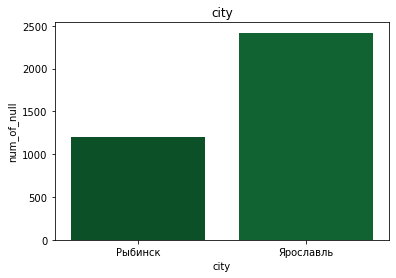

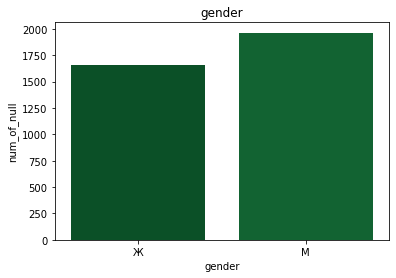

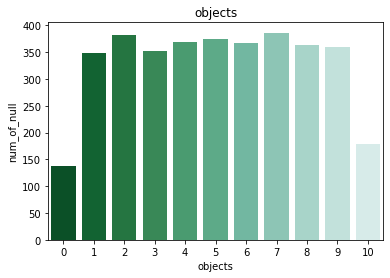

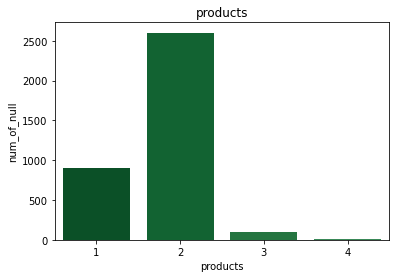

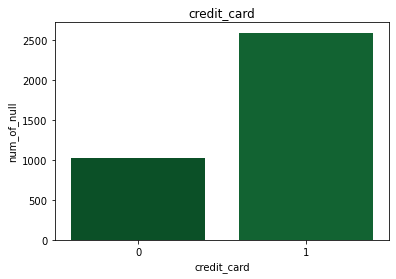

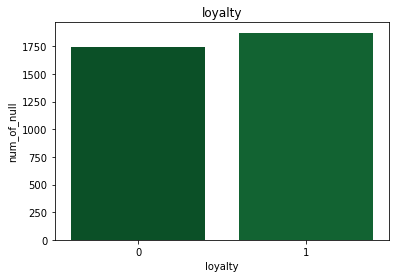

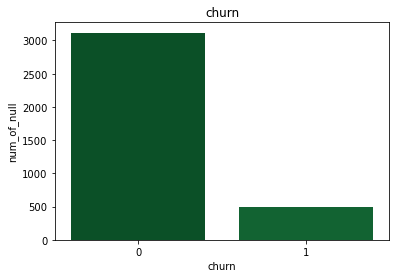

In [ ]:
# выбор тех строк датафрейма, в которых пропущены значения balance
nan_balance_df = df.query('balance.isnull()', engine='python')

for v in signs:
    pivot_table = nan_balance_df.groupby(v).agg({'user_id':'count'}).reset_index().rename(columns={'user_id':'num_of_null'})
    plt.title(v)
    sns.barplot(x=pivot_table[v], y=pivot_table['num_of_null'], palette=sns.color_palette("BuGn_r", 13))
    plt.show()

### Вывод:
Для города Ростов Великий кол-во пропусков balance 0. Это может говорить о том, что клиентов в Ростове привлекли за счет зарплатного проекта.

Так как в исследовании нет этапа машинного обучения, то от пропусков можно не избавляться. t-тесты нечувствительны к пропускам.

## Исследовательский анализ данных

### Функции для построения графиков

In [ ]:
## функция для визуализации количественных признаков
def quantity_signs_viz(data, sign):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    #построение графика распределения признака
    sns.distplot(data[sign], ax=ax1, color = '#6DAB47')
    #построение диаграммы разброса значений признака
    data[sign].plot.box(ax=ax2, grid=True, color = '#6DAB47')
    ax1.set_title('Распределение '+sign)
    ax2.set_title('Разброс значений для '+sign)
    plt.show();

## функция для визуализации качественных признаков
def quality_signs_viz(data, sign):
    #данные для построения
    sign_data = data[sign].value_counts().sort_index()
    #построение столбчатой диаграммы
    plt.figure(figsize=(14, 4), dpi=80)
    plt.subplot(121)
    bar = sign_data.plot(kind='bar', color = '#92B18B')
    plt.xlabel("Значения признака "+sign)
    plt.ylabel("Кол-во записей для значения признака "+sign)
    plt.title('Сравнение значений признака '+sign)
    #построение круговой диаграммы
    plt.subplot(122)
    #добавление цветов
    colors = ['#92B18B','#AFD498','#8CC26A','#6DAB47']
    pie = plt.pie(sign_data.values,labels=sign_data.index, autopct='%1.1f%%', colors=colors, shadow=True, startangle=90)
    plt.xticks(rotation=45)
    plt.title('Доля каждого значения признака в общем объеме')

    plt.legend()
    plt.show()

# функция для построения распределений признаков в зависимости от зн-ия парметра churn
def feat_hist(x, group_col, key_cols):
    x_new = x.copy()[key_cols]

    quality_signs = ['city', 'gender', 'objects','products', 'credit_card','loyalty', 'churn']



    for c in key_cols:
        #пропускаю группировочную переменную и 'user_id', т.к. ее исследовать бесполезно:
        if c == group_col or c =='user_id': continue

        # качественные признаки
        if c in quality_signs:
            report = x_new.reset_index().pivot_table(index = c, columns = group_col, values = 'index', aggfunc = 'count')
            print(report)
            report.plot(kind = 'bar', stacked = True, alpha = 0.5, colormap = 'PiYG')
        else:

            for cl in x[group_col].unique():

                # переключение цвета
                if cl == 0:
                    color ='#8B1648'
                else:
                    color = '#92B18B'

                sns.distplot(x_new[x_new[group_col]==cl][c],
                              label='{} = {}'.format(group_col, str(cl)), bins = 10, color=color)


        plt.title(c)
        plt.legend()
        plt.show();

### Изучение признаков ['city', 'gender', 'objects','products', 'credit_card','loyalty', 'churn']

Признак city


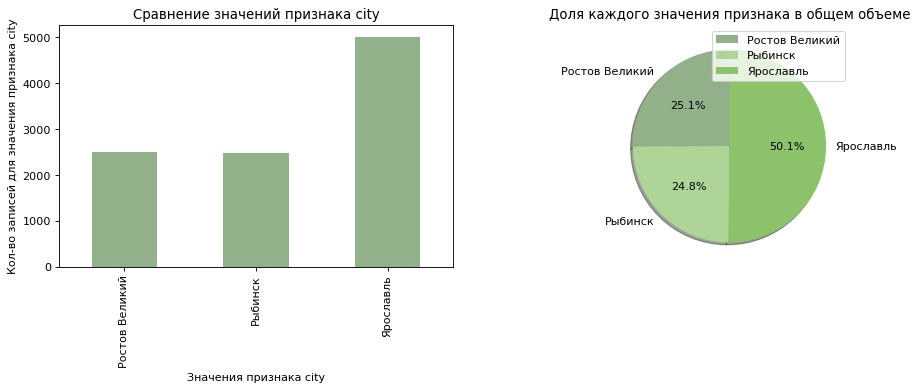




Признак gender


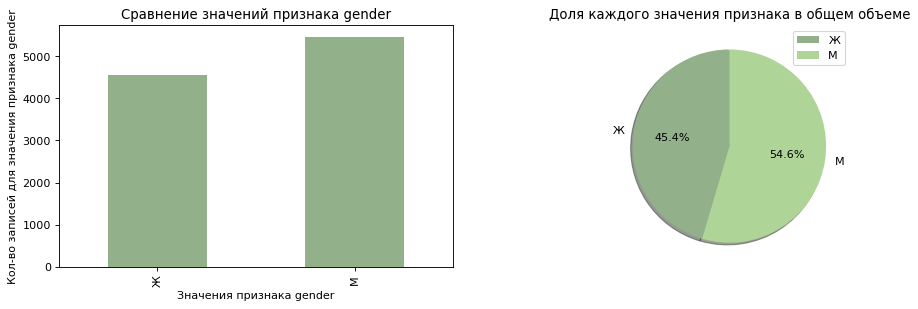




Признак objects


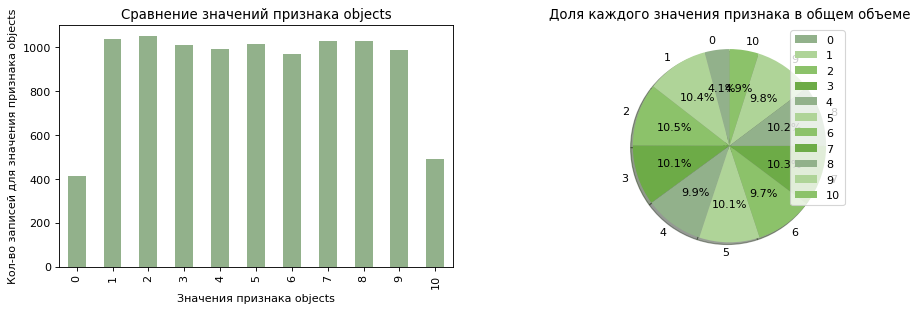




Признак products


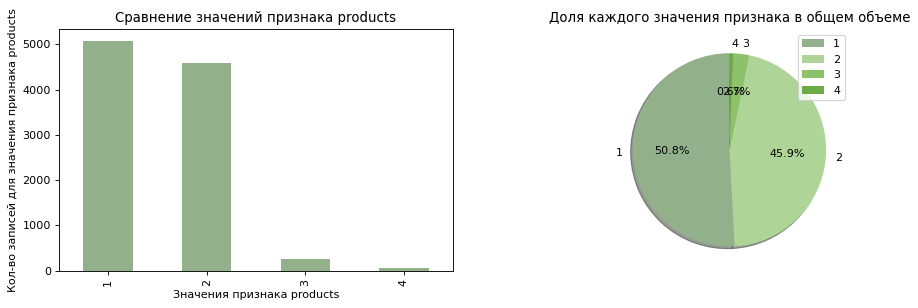




Признак credit_card


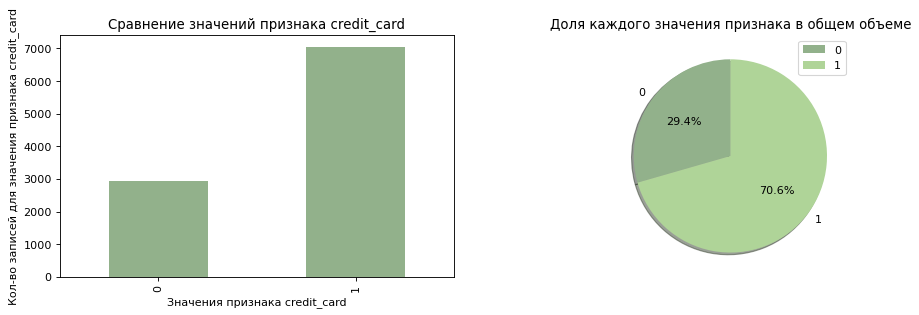




Признак loyalty


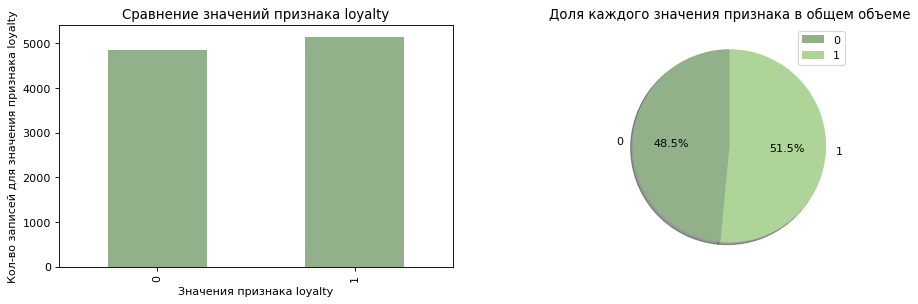




Признак churn


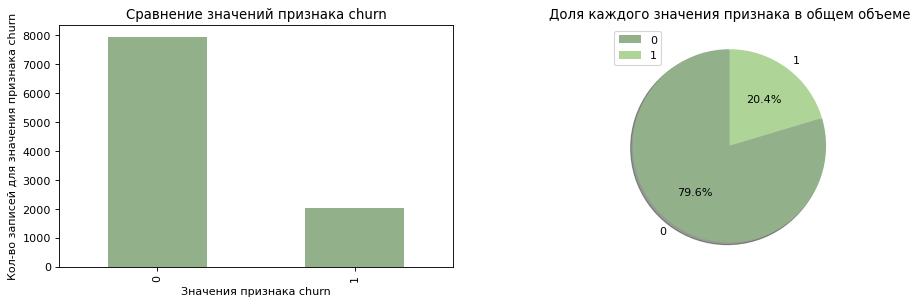

In [ ]:
signs_1 = ['city', 'gender', 'objects','products', 'credit_card','loyalty', 'churn']
for sign in signs_1:
    print('Признак', sign)
    quality_signs_viz(df, sign)
    print(end='\n\n\n')

### Вывод
    - 50% клиентов из Ярославля, 25% из Ростова Великого и 25% из Рыбинска;
    - 55% клиентов мужчины, 45% - женщины;
    - распределение количества объектов недвижимости во владении клиентов равномерное для зн-ий от 1 до 9 (~10% клиентов на каждое значение). Оставшиеся 10 % клиентов владеют 10 объектами недвижимости или вообще не владеют ничем;
    - 51% клиентов используют только 1 продукт банка, 46% используют два продукта;
    - 71% клиентов имеют кредитную карту;
    - 52% клиентов считаются активными;
    - 20% клиентов ушли от банка

### Изучение признаков ['score','balance','estimated_salary',  'age']

Признак score
count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: score, dtype: float64


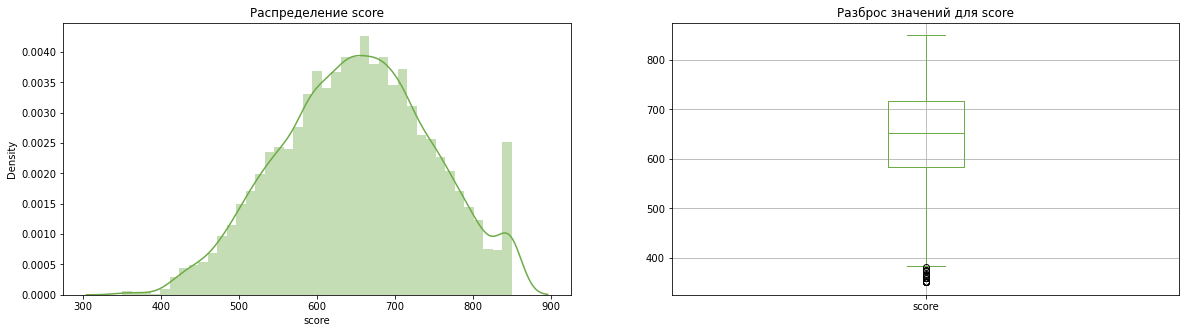


Признак balance
count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: balance, dtype: float64


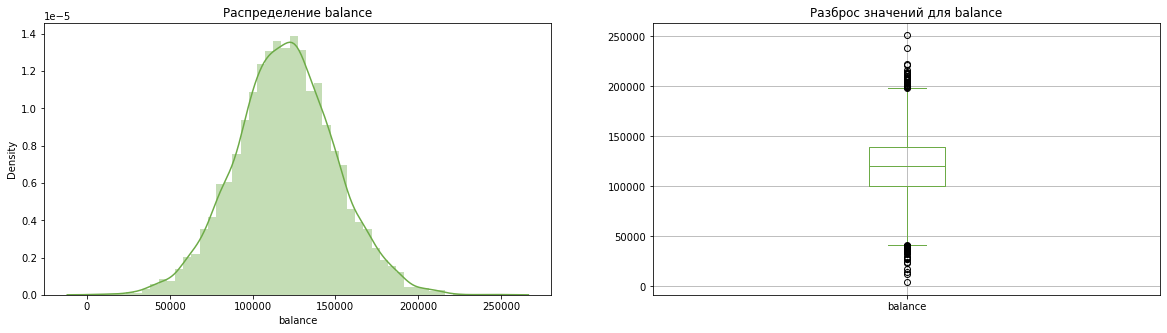


Признак estimated_salary
count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64


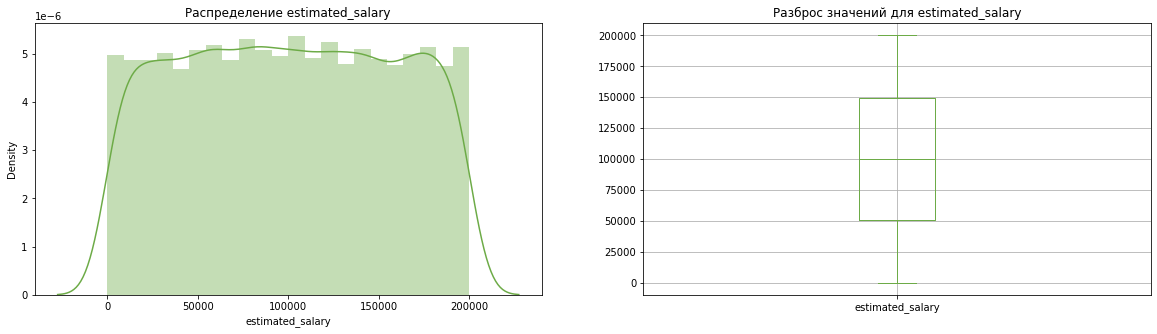


Признак age
count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64


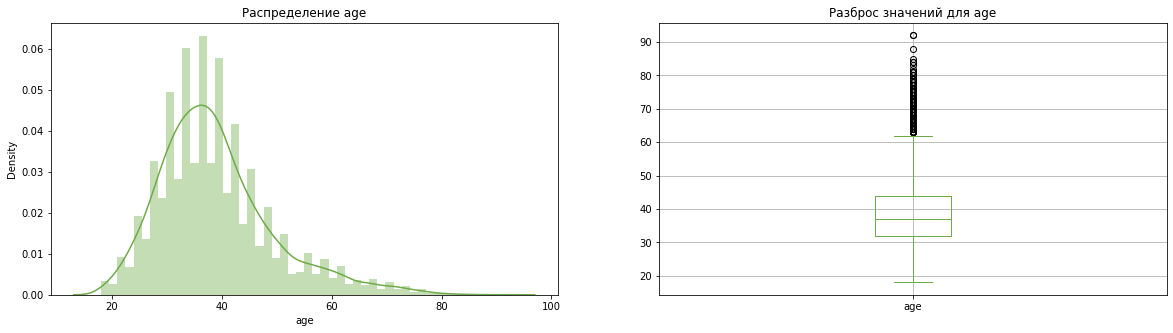

In [ ]:
signs_2 = ['score','balance','estimated_salary', 'age']
for v in signs_2:
    print('Признак', v)
    print(df[v].describe())
    quantity_signs_viz(df,v)
    print()

### Вывод
    - score:
    Баллы кредитного скоринга распределены нормально с пиком в районе зн-ия 650. Наблюдается пик в районе 850.
    В среднем, чтобы кредит был одобрен значение скорингового балла должно быть не менее 600 баллов(информация из google). Получается, что немного более половины от общего числа клиентов получают одобрение на кредит;
    -balance:
    Зн-ие баланса на счетах клиентов распределены нормально с пиком в районе зн-ия 120 000 у.е;
    -estimated_salary:
    Оцененная зарплата распределена равномерно от 0 до 200 000. Минимальные зн-ия связаны с тем, что алгоритм оценки зп клиента расчитал такую величину исходя из малых расходов клиента;
    -age:
    Возраст клиентов распределен нормально с нижним пределом в 18 лет. Пик нормального распределения приходится на зн-ие 38.

### Построение матрицы корреляций

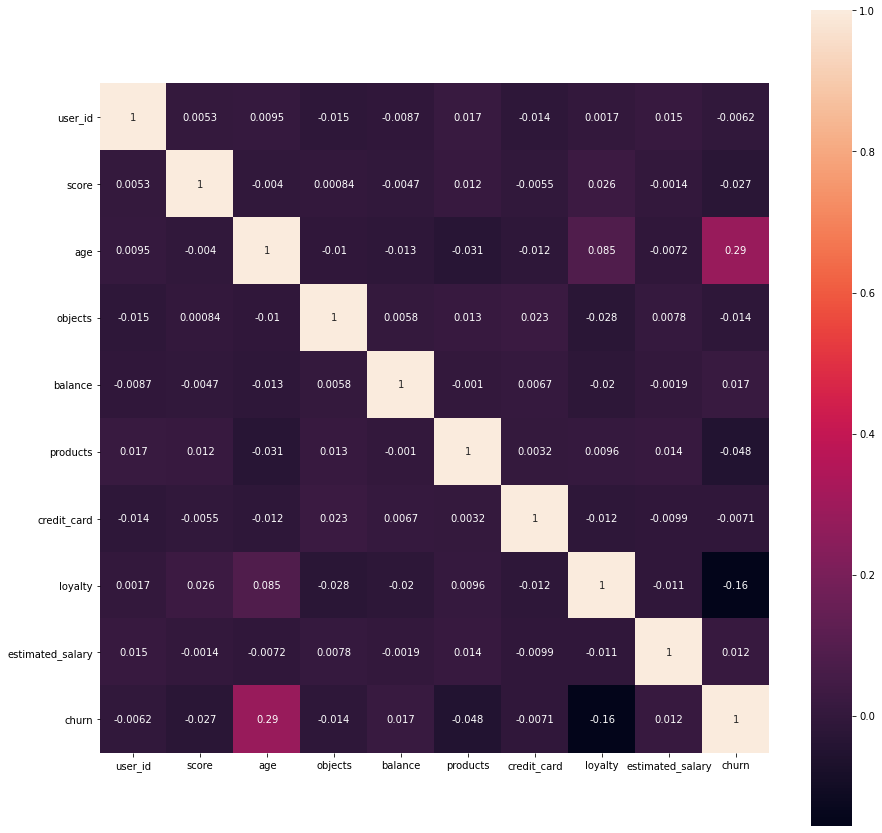

In [ ]:
corr_m = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_m, square = True, annot = True)
plt.show();

### Вывод

Значимая корреляция наблюдается между признаками age и churn.

### Построение столбчатых гистограмм и распределений признаков для тех клиентов, кто ушёл и тех, кто остался

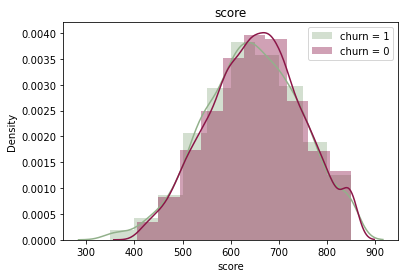

churn              0    1
city                     
Ростов Великий  1695  814
Рыбинск         2064  413
Ярославль       4204  810


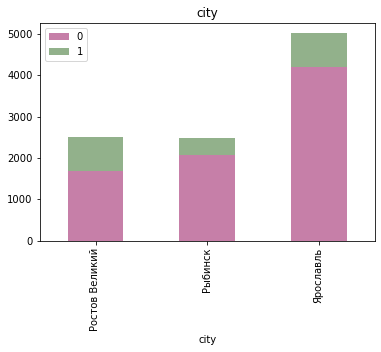

churn      0     1
gender            
Ж       3404  1139
М       4559   898


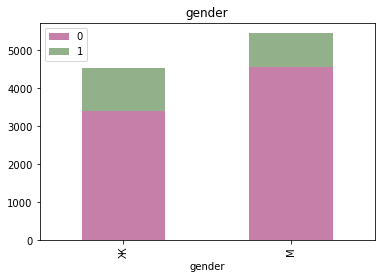

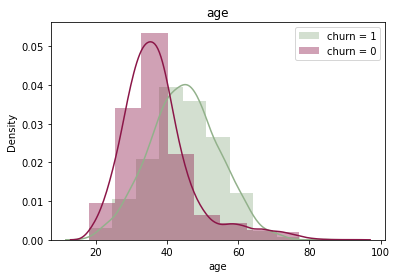

churn      0    1
objects          
0        318   95
1        803  232
2        847  201
3        796  213
4        786  203
5        803  209
6        771  196
7        851  177
8        828  197
9        771  213
10       389  101


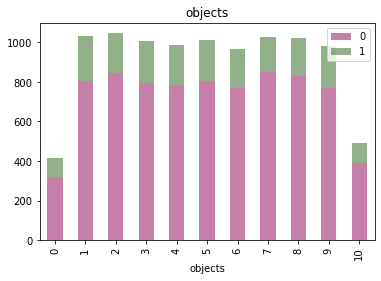

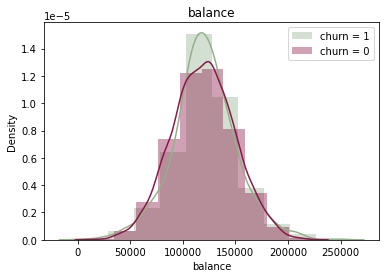

churn          0       1
products                
1         3675.0  1409.0
2         4242.0   348.0
3           46.0   220.0
4            NaN    60.0


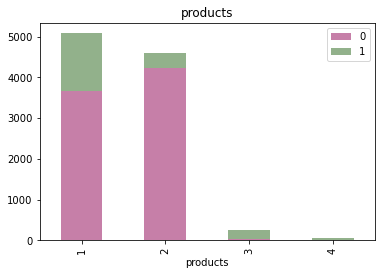

churn           0     1
credit_card            
0            2332   613
1            5631  1424


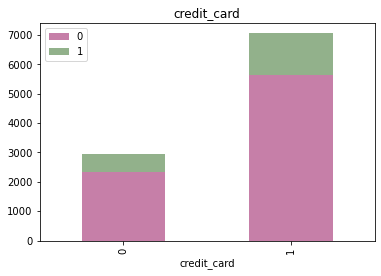

churn       0     1
loyalty            
0        3547  1302
1        4416   735


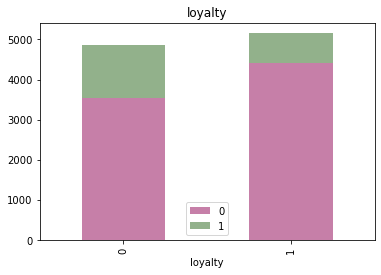

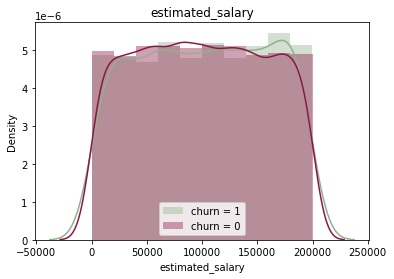

In [ ]:
feat_hist(df,'churn', df.columns)

### Вывод
    - score:
    Распределение баллов кредитного скоринга для клиентов, которые ушли достигает пика раньше, чем распределение для клиентов, которые остались с банком. Это говорит о том, что машина кредитного скоринга оценила таких клиентов, как менее надежных заемщиков
    - city:
    Больше всего ушедших клиентов из Ростова Великого - это число примерно в два раза больше, чем для Рыбинска, в котором обслуживается столько же клиентов (25% от общего объема)
    - gender:
    Больше всего ушедших клиентов было женщинами
    - age:
    Возраст покинувших банк клиентов больше возраста тех, кто остались. В среднем на 10 лет. Средний возраст покинувших банк клиентов около 45. Оставшихся около 35.
    - oblects:
    Закономерность не выявлена.
    - products:
    БОльшая часть ушедших клиентов пользовалась одним продуктом. Несмотря на то, что больше всего клиентов используют только один продукт, в результате ухода картина поменялась и теперь больше тех клинтов, которые пользуются двумя продуктами;
    -credit_card:
    Закономерность не обнаружена;
    -loyalty:
    Закономерность не обнаружена;
    -estimated_salary:
    Закономерность не обнаружена;
    

## Сегментация клиентов

Отчетливо видно различие в возрасте между клиентами, которые остались и теми, которые ушли в отток.

In [ ]:
# функция для вычисления зн-ия экстремума y по оси х
# используется для того, чтобы определить наиболее вероятное зн-ие age в рассматриваемом сегменте
def extremum_point(graph_points):
    #print(graph_points)

    #экстремум функции
    y_extremum_value = graph_points[1].max()

    #индекс экстремума функции в массиве значений
    y_extremum_position = np.where(graph_points[1] == y_extremum_value)[0][0]

    #поиск значения оси х по индексу extremum_index
    x_extremum_value =  graph_points[0][y_extremum_position]

    return(x_extremum_value)


Наиболее вероятное зн-ие age для ушедших клиентов: 45.26115964277402


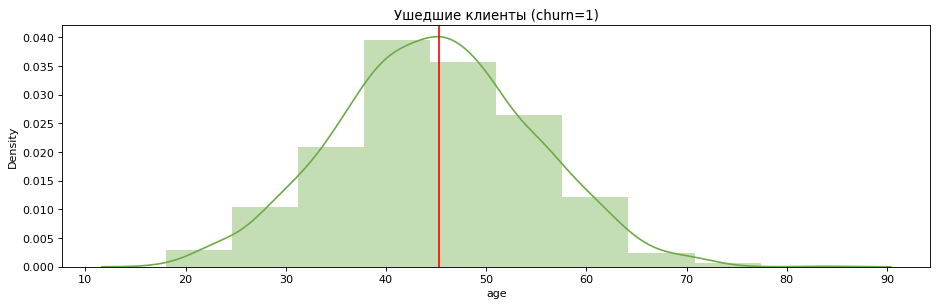

In [ ]:
#построение графика распределения для тех, кто ушел (churn=1)

#задание размера графика
plt.figure(figsize=(14, 4), dpi=80)
#создание объекта distplot
departed_clients_graph = sns.distplot(df[df['churn']==1]['age'], bins = 10, color = '#6DAB47')
#получение зн-ий, по которым будет строится график distplot для дальнейшего вычисления экстремума
departed_clients_graph_data = departed_clients_graph.get_lines()[0].get_data()
#использование ф-ии для вычисления значения экстремума по оси х
departed_clients_extremum = extremum_point(departed_clients_graph_data)
print('Наиболее вероятное зн-ие age для ушедших клиентов:', departed_clients_extremum)
#построение горизонтальной прямой, проходящей через экстремум
plt.axvline(x = departed_clients_extremum, color='r',label = 'extremum')
plt.title('Ушедшие клиенты (churn=1)')
plt.show();

Наиболее вероятное зн-ие age для оставшихся клиентов: 35.35378416736096


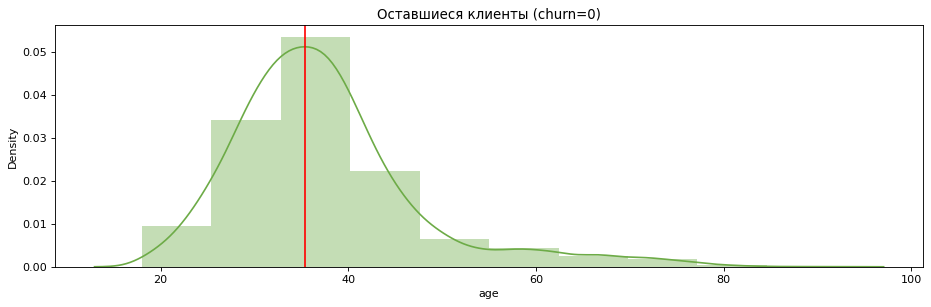

In [ ]:
#построение графика распределения для тех, кто остался (churn=0)

#задание размера графика
plt.figure(figsize=(14, 4), dpi=80)
#создание объекта distplot
remaining_clients_graph = sns.distplot(df[df['churn']==0]['age'], bins = 10, color = '#6DAB47')
#получение зн-ий, по которым будет строится график distplot для дальнейшего вычисления экстремума
remaining_clients_graph_data = remaining_clients_graph.get_lines()[0].get_data()
#использование ф-ии для вычисления значения экстремума по оси х
remaining_clients_extremum = extremum_point(remaining_clients_graph_data)
print('Наиболее вероятное зн-ие age для оставшихся клиентов:', remaining_clients_extremum)
#построение горизонтальной прямой, проходящей через экстремум
plt.axvline(x = remaining_clients_extremum, color='r',label = 'extremum')
plt.title('Оставшиеся клиенты (churn=0)')
plt.show();

In [ ]:
#установлю границу раздела как:
divide_value = round(remaining_clients_extremum + (departed_clients_extremum - remaining_clients_extremum)/2)
print('Граница раздела:',divide_value)

Граница раздела: 40


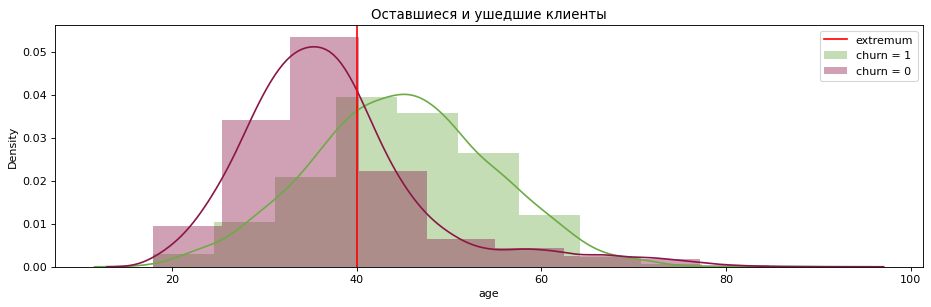

In [ ]:
plt.figure(figsize=(14, 4), dpi=80)

for cl in df['churn'].unique():

    # переключение цвета
    if cl == 0:
        color ='#8B1648'
    else:
        color = '#6DAB47'

    graph = sns.distplot(df[df['churn']==cl]['age'],label='{} = {}'.format('churn', str(cl)), bins = 10, color = color)


plt.axvline(x = divide_value, color='r',label = 'extremum')
plt.title('Оставшиеся и ушедшие клиенты')
plt.legend()
plt.show();

**Проверка полученных значений**

Есть альтернативный способ найти среднее значения age для тех кто ушел в отток и кто остался — использовать функцию mean()

In [ ]:
print('Средний возраст тех, кто ушел в отток, расчитанный первым способом', departed_clients_extremum)
print('Средний возраст тех, кто ушел в отток, расчитанный вторым способом', df.query('churn==1')['age'].mean())
print('Средний возраст тех, кто остался, расчитанный первым способом', remaining_clients_extremum)
print('Средний возраст тех, кто остался, расчитанный вторым способом', df.query('churn==0')['age'].mean())

Средний возраст тех, кто ушел в отток, расчитанный первым способом 45.26115964277402
Средний возраст тех, кто ушел в отток, расчитанный вторым способом 44.8379970544919
Средний возраст тех, кто остался, расчитанный первым способом 35.35378416736096
Средний возраст тех, кто остался, расчитанный вторым способом 37.40838879819164


**Вывод**

Как видно, значения очень близки, а значит расчет сделан верно.

#### Применение метода apply для категоризации

In [ ]:
def age_categorization(age):

    if age > divide_value:
        return 'old'

    return 'young'


In [ ]:
df['age_category'] = df['age'].apply(age_categorization)

#### Отток в зависимости от сегмента

In [ ]:
num_of_young = df.query('age_category == "young"')['user_id'].count()
num_of_old = df.query('age_category == "old"')['user_id'].count()
print('Кол-во клиентов моложе 40 лет из категории young:', num_of_young)
print('Кол-во клиентов старше 40 лет из категории old:', num_of_old)

young_churn = df.query('age_category == "young"')['churn'].mean() * 100
old_churn = df.query('age_category == "old"')['churn'].mean() * 100
delta_perc = (old_churn - young_churn)

print('Отток в категории old: ', old_churn,'%')
print('Отток в категории young: ', young_churn,'%')
print('Разница между оттоком категории old и оттоком категории young: ', delta_perc,'%')


Кол-во клиентов моложе 40 лет из категории young: 6419
Кол-во клиентов старше 40 лет из категории old: 3581
Отток в категории old:  37.7268919296286 %
Отток в категории young:  10.687022900763358 %
Разница между оттоком категории old и оттоком категории young:  27.03986902886524 %


### Вывод:

Клиенты разделены на два сегмента по возрастному признаку. Граница раздела приходится на значение age равное 40.
 - Отток для клиентов старше 40 лет: **37.7%**
 - Отток для клиентов младше 40 лет: **10.7%**
 - Разница составляет **27%**

### Различие признаков клиентов в зависимости от возрастной категории

Признак city значение old


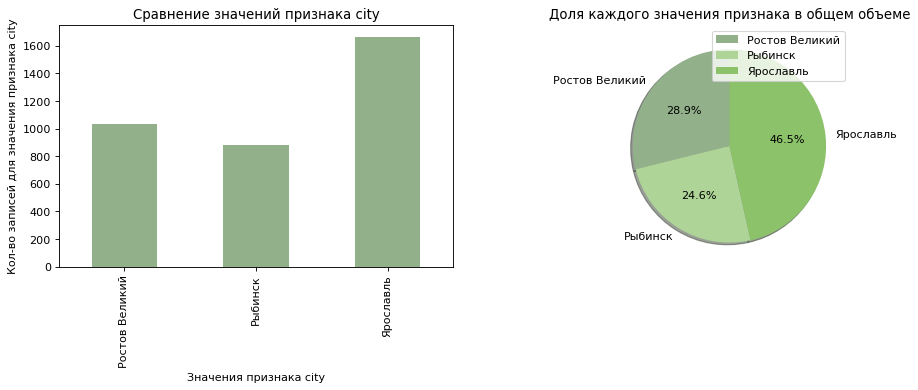

Признак city значение young


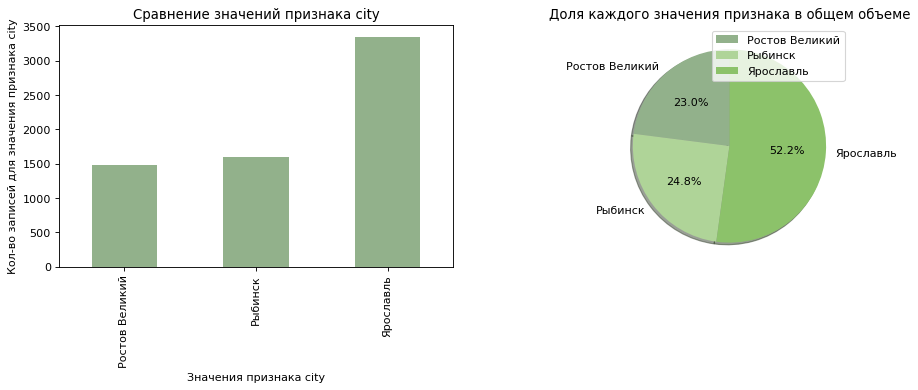




Признак gender значение old


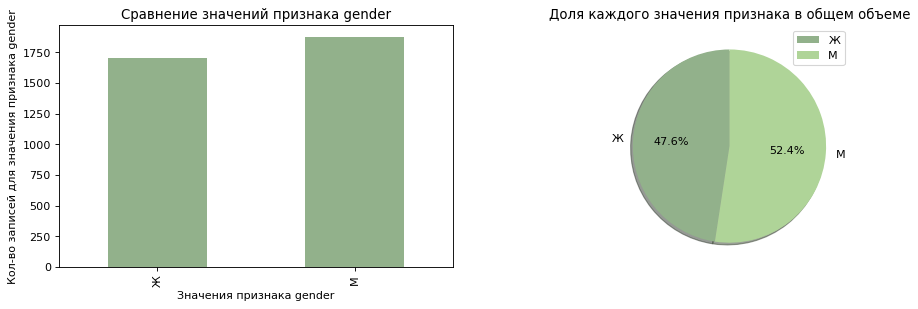

Признак gender значение young


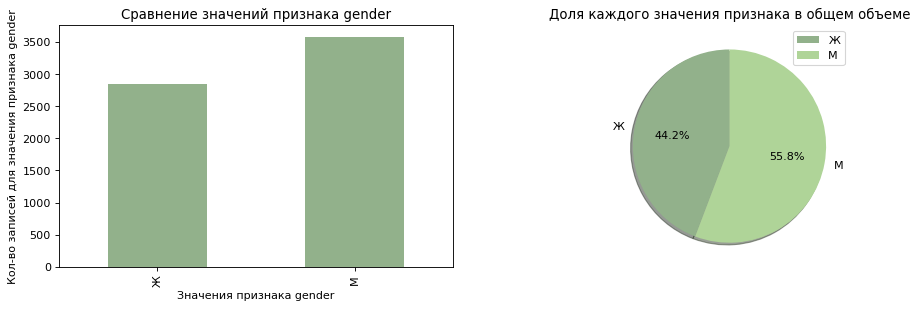




Признак objects значение old


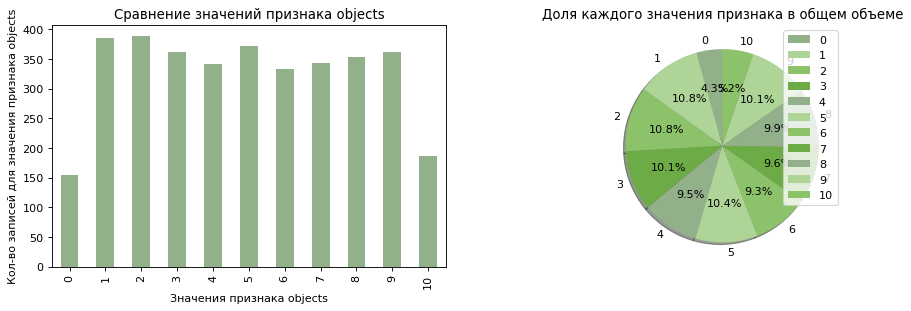

Признак objects значение young


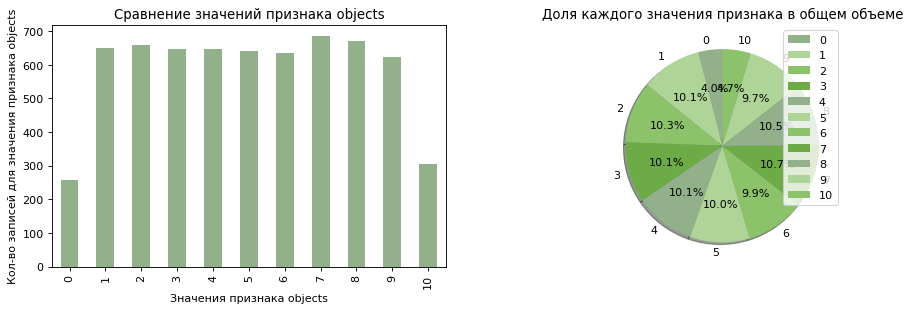




Признак products значение old


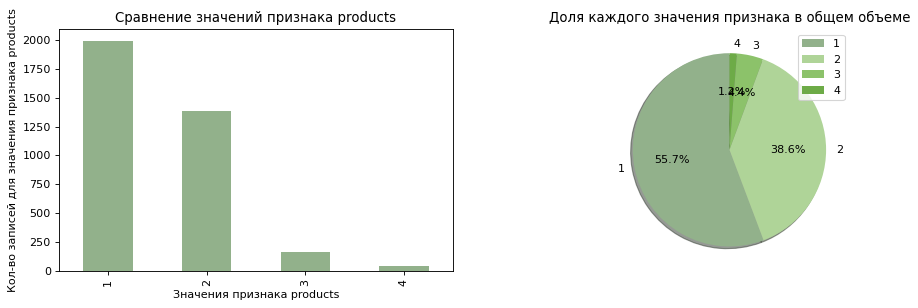

Признак products значение young


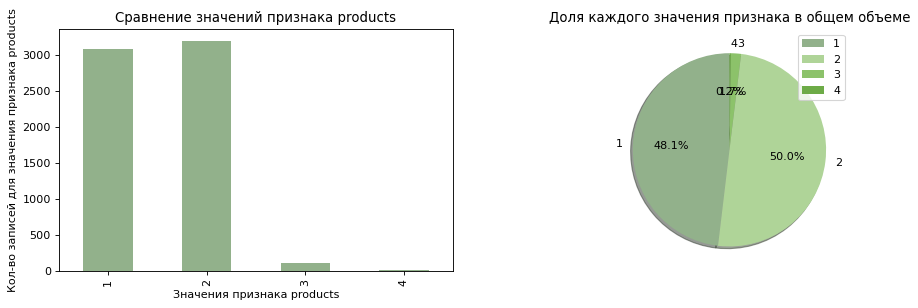




Признак credit_card значение old


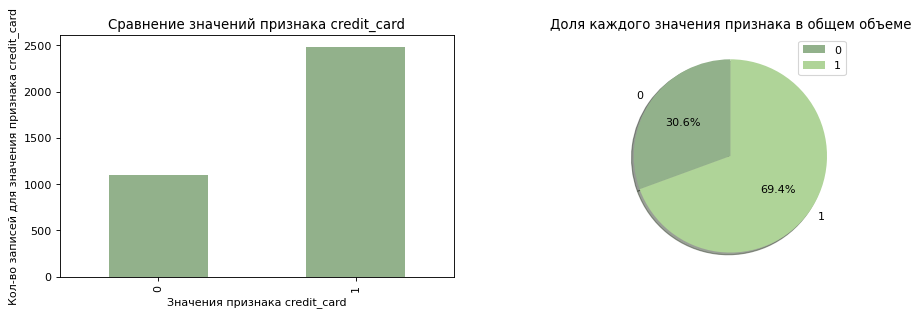

Признак credit_card значение young


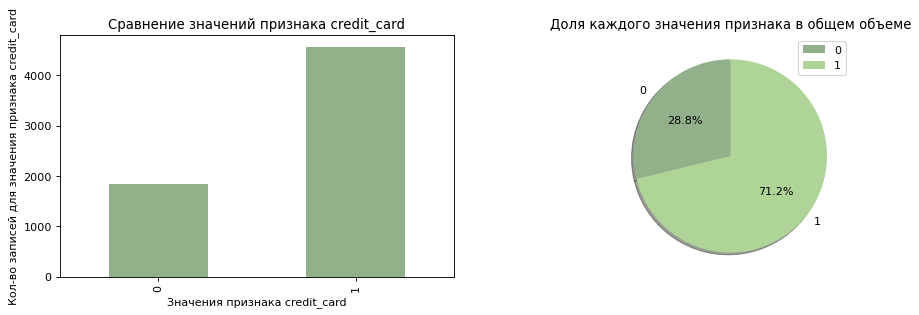




Признак loyalty значение old


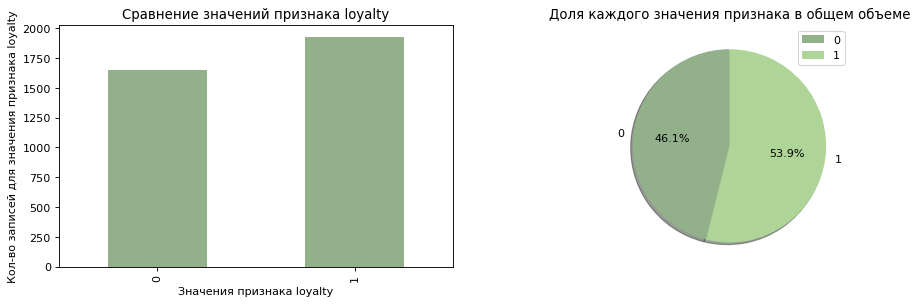

Признак loyalty значение young


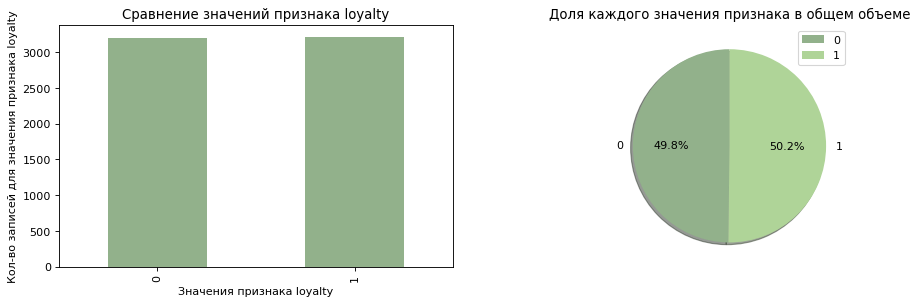




Признак churn значение old


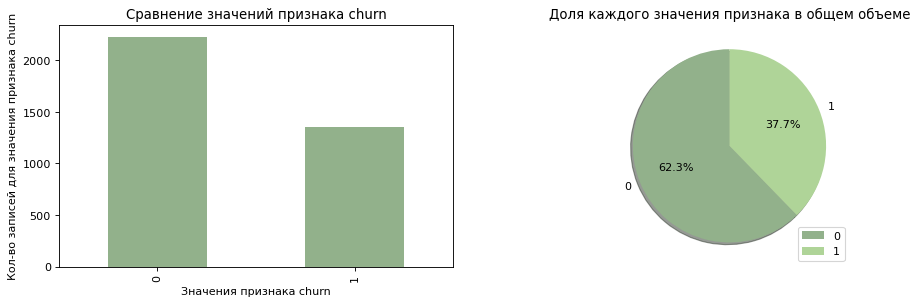

Признак churn значение young


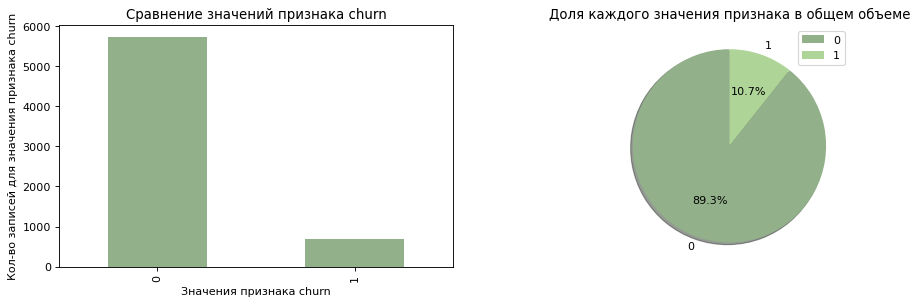

In [ ]:
signs_3 = ['city', 'gender', 'objects', 'products', 'credit_card', 'loyalty','churn']
categories = ["old", "young"]
for sign in signs_3:
    for category in categories:
        print('Признак', sign, 'значение', category)
        data_slice = df.query('age_category == @category').reset_index()
        quality_signs_viz(data_slice, sign)
    print(end='\n\n\n')

Признак score значение old
count    3581.000000
mean      649.087685
std        96.016567
min       350.000000
25%       584.000000
50%       649.000000
75%       715.000000
max       850.000000
Name: score, dtype: float64


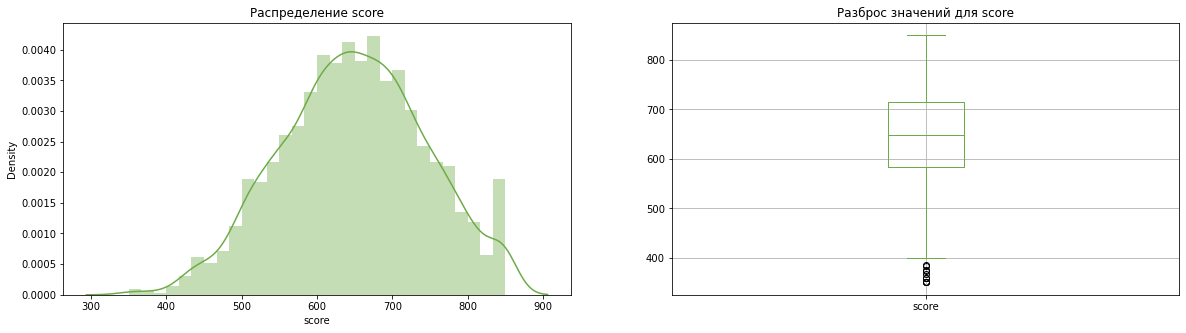

Признак score значение young
count    6419.000000
mean      651.332762
std        97.004854
min       350.000000
25%       584.000000
50%       653.000000
75%       718.000000
max       850.000000
Name: score, dtype: float64


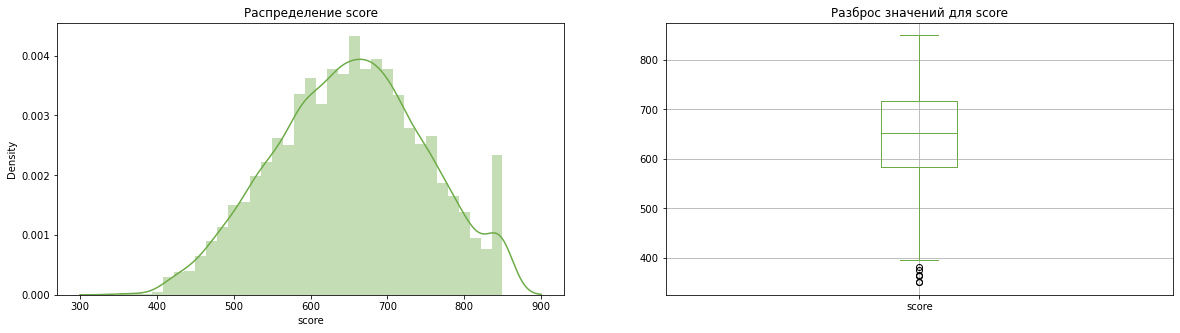




Признак balance значение old
count      2381.000000
mean     119438.126459
std       30030.726602
min       12459.190000
25%       99906.890000
50%      119655.770000
75%      138778.150000
max      238387.560000
Name: balance, dtype: float64


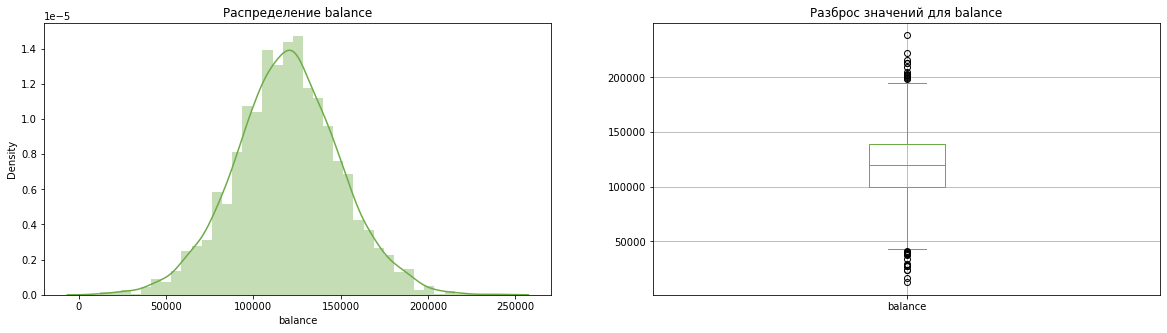

Признак balance значение young
count      4002.000000
mean     120059.148871
std       30134.626450
min        3768.690000
25%      100343.355000
50%      120061.370000
75%      139747.397500
max      250898.090000
Name: balance, dtype: float64


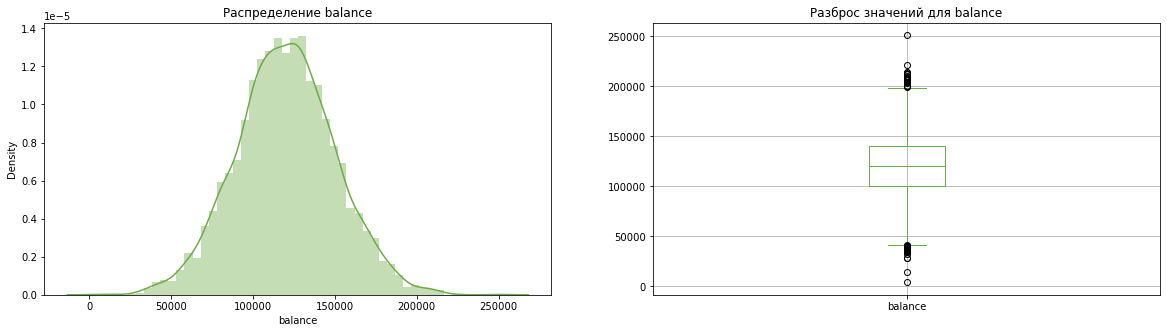




Признак estimated_salary значение old
count      3581.000000
mean     100449.310821
std       57378.419003
min          11.580000
25%       51636.700000
50%      100183.050000
75%      149756.710000
max      199992.480000
Name: estimated_salary, dtype: float64


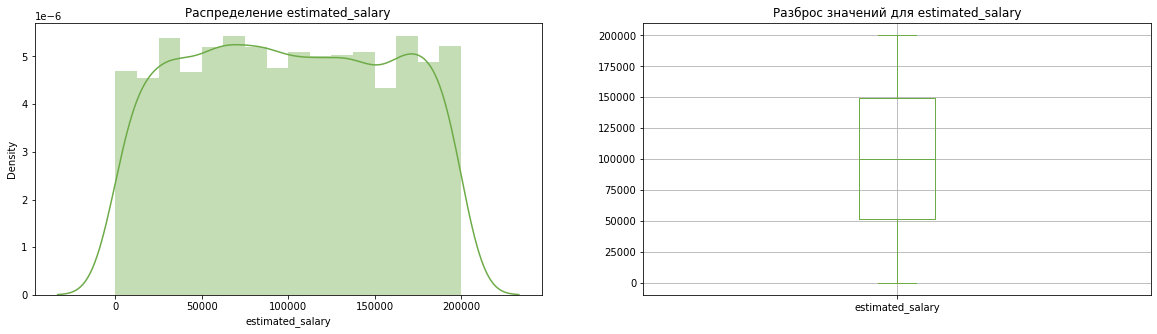

Признак estimated_salary значение young
count      6419.000000
mean      99889.923159
std       57587.534253
min          90.070000
25%       50573.210000
50%      100240.200000
75%      148985.595000
max      199953.330000
Name: estimated_salary, dtype: float64


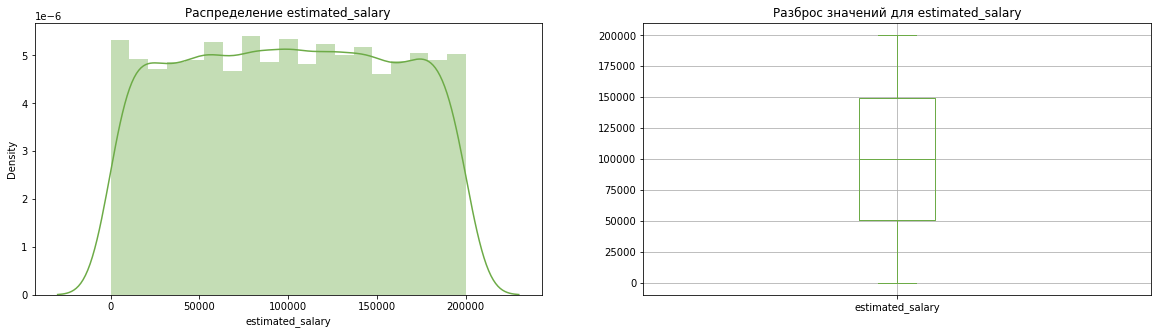

In [ ]:
signs_4 = ['score','balance','estimated_salary']
for sign in signs_4:
    for category in categories:
        print('Признак', sign, 'значение', category)
        data_slice = df.query('age_category == @category').reset_index()
        print(data_slice[sign].describe())
        quantity_signs_viz(data_slice,sign)

    print(end='\n\n\n')

### Вывод:

Между возрастными категориями клиентов old и young выявляются следующие явные отличия:

    - Клиенты из категории old чаще пользуются 1 банковским продуктом. И, напротив, клиенты категории young чаще являются пользователями 2 банковских продуктов;
    - Клиенты из категории old более активны, чем клиенты категории young. Разница в показателе loyalty составляет около 4%.

## Проверка гипотез относительно поведения клиентов

### Гипотеза о различии дохода между теми клиентами, которые ушли и теми, которые остались

Для проверки гипотезы будет применен t-критерий Стьюдента. Формулировки гипотез:

**Нулевая гипотеза $H_0$**: средний доход клиентов, которые остались равен среднему доходу клиентов, которые ушли.

**Альтернативная гипотеза $H_1$ (двусторонняя)**: средний доход клиентов, которые остались и средний доход клиентов, которые ушли, различаются.

Для проверки двусторонней гипотезы о равенстве (различии) средних двух независимых выборок подойдет метод scipy.stats.ttest_ind

In [ ]:
# разделяю клиентов по признаку churn
departed_clients_salary = df.query('churn == 1').reset_index()['estimated_salary']
remaining_clients_salary = df.query('churn == 0').reset_index()['estimated_salary']
print('Размер departed_clients_salary', len(departed_clients_salary))
print('Размер remaining_clients_salary', len(remaining_clients_salary))

# задаю уровень статистической значимости
# если p-value окажется меньше него - отвергаю гипотезу H0
aplha = .05

# использование метода ttest_ind
results = st.ttest_ind (
    departed_clients_salary,
    remaining_clients_salary,
    # equal_var=True, т.к. выборки сильно отличаются по размеру
    equal_var=True
)
print('p-value =', results.pvalue)

if results.pvalue < aplha:
    print('Есть основания отвергнуть H0 и принять альтернативную гипотезу H1 за верную')
else:
    print('Нет оснований отвергнуть H0')

Размер departed_clients_salary 2037
Размер remaining_clients_salary 7963
p-value = 0.22644042802223346
Нет оснований отвергнуть H0


### Вывод:
Нет оснований отрицать, что средний доход клиентов, которые остались равен среднему доходу клиентов, которые ушли

### Гипотеза о различии среднего количества баллов кредитного скоринга между клиентами из возрастных категорий old и young

In [ ]:
# Расчет среднего кол-ва баллов кредитного скоринга в зависимости от возрастной категории клиента:
old_clients_avg_score = df.query('age_category == "old"').reset_index()['score'].mean()
young_clients_avg_score = df.query('age_category == "young"').reset_index()['score'].mean()
print('Среднее кол-во баллов кредитного скоринга для клиентов из возрастной категории old:', old_clients_avg_score)
print('Среднее кол-во баллов кредитного скоринга для клиентов из возрастной категории young:', young_clients_avg_score)

Среднее кол-во баллов кредитного скоринга для клиентов из возрастной категории old: 649.0876850041888
Среднее кол-во баллов кредитного скоринга для клиентов из возрастной категории young: 651.3327621124786


Для проверки гипотезы будет применен t-критерий Стьюдента. Формулировки гипотез:

**Нулевая гипотеза $H_0$**: среднее количетсво баллов кредитного скоринга для клиентов из возрастной категории old равно среднему количеству баллов для клиентов из возрастной категории young

**Альтернативная гипотеза $H_1$ (односторонняя)**: среднее количетсво баллов кредитного скоринга для клиентов из возрастной категории young больше среднего кол-ва баллов для клиетов из возрастной категории old

Проверив эту гипотезу можно будет сделать вывод о том, каких клиентов выгоднее привлекать. Если подтвердится, что среднее кол-во баллов кредитного скоринга для клиентов из возрастной категории young выше, то это значит, что таким клиентам будут чаще одобрять кредиты и вложения на их привлечение будут окупаться лучше в сравнении с категорией old

In [ ]:
# разделяю клиентов по признаку age_category
old_clients_score = df.query('age_category == "old"').reset_index()['score']
young_clients_score = df.query('age_category == "young"').reset_index()['score']
print('Размер old_clients_score', len(old_clients_score))
print('Размер young_clients_score', len(young_clients_score))

# задаю уровень статистической значимости
aplha = .05

# использование метода ttest_ind
results = st.ttest_ind (
    old_clients_score,
    young_clients_score,
    # equal_var=True, т.к. выборки сильно отличаются по размеру
    equal_var=True
)
print('p-value =', results.pvalue)

if (results.pvalue/2 < aplha) and (old_clients_avg_score < young_clients_avg_score):
    print('Есть основания отвергнуть H0 и принять альтернативную гипотезу H1 за верную')
else:
    print('Нет оснований отвергнуть H0')


Размер old_clients_score 3581
Размер young_clients_score 6419
p-value = 0.2654485185728313
Нет оснований отвергнуть H0


### Вывод:
Нет оснований отрицать, что среднее количетсво баллов кредитного скоринга для клиентов из возрастной категории old равно среднему количеству баллов для клиентов из возрастной категории young

## Выводы

### Описание выделенных портретов клиентов

**Общие характерные черты:**
- 50% клиентов из Ярославля, 25% из Ростова Великого и 25% из Рыбинска;
- 55% клиентов мужчины, 45% - женщины;
- распределение количества объектов недвижимости во владении клиентов равномерное для зн-ий от 1 до 9 (~10% клиентов на каждое значение). Оставшиеся 10 % клиентов владеют 10 объектами недвижимости или вообще не владеют ничем;
- 51% клиентов используют только 1 продукт банка, 46% используют два продукта;
- 71% клиентов имеют кредитную карту;
- 52% клиентов считаются активными;
- 20% клиентов ушли от банка;
-Баллы кредитного скоринга распределены нормально с пиком в районе зн-ия 650. Наблюдается пик в районе 850.
В среднем, чтобы кредит был одобрен значение скорингового балла должно быть не менее 600 баллов(информация из google). Получается, что немного более половины от общего числа клиентов получают одобрение на кредит;
- Зн-ие баланса на счетах клиентов распределены нормально с пиком в районе зн-ия 120 000 у.е;
- Оцененная зарплата распределена равномерно от 0 до 200 000. Минимальные зн-ия связаны с тем, что алгоритм оценки зп клиента расчитал такую величину исходя из малых расходов клиента;
- Возраст клиентов распределен нормально с нижним пределом в 18 лет. Пик нормального распределения приходится на зн-ие 38.

**!Значимая корреляция наблюдается между признаками age и churn!**

**Клиенты разделены на два сегмента по возрастному признаку. Граница раздела приходится на значение age равное 40**
 - Отток для клиентов старше 40 лет: **37.7%**
 - Отток для клиентов младше 40 лет: **10.7%**
 - Разница составляет **27%**

**Между возрастными категориями клиентов выявляются следующие явные отличия:**
- Клиенты старше 40 чаще пользуются 1 банковским продуктом. И, напротив, клиенты младше 40 чаще являются пользователями 2 банковских продуктов;
- Клиенты из старшей категории более активны. Разница в показателе loyalty составляет около 4%.

**Описание признаков для клиентов, которые ушли от банка:**
- Распределение баллов кредитного скоринга для клиентов, которые ушли достигает пика раньше, чем распределение для клиентов, которые остались с банком. Это говорит о том, что машина кредитного скоринга оценила таких клиентов, как менее надежных заемщиков;
- Больше всего ушедших клиентов из Ростова Великого - это число примерно в два раза больше, чем для Рыбинска, в котором обслуживается столько же клиентов (25% от общего объема);
-БОльшая часть ушедших клиентов пользовалась одним продуктом. Несмотря на то, что больше всего клиентов используют только один продукт, в результате ухода картина поменялась и теперь больше тех клинтов, которые пользуются двумя продуктами.

Проверка гипотез дала следующие результаты:
 - Нет оснований отрицать, что средний доход клиентов, которые остались равен среднему доходу клиентов, которые ушли;
 - Нет оснований отрицать, что среднее количетсво баллов кредитного скоринга для клиентов старше 40 равно среднему количеству баллов для клиентов младше 40;

### Рекомендации по улучшению взаимодействия с каждым сегментом